# [Building micrograd](https://youtu.be/VMj-3S1tku0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)
Karis, 11/24

Video is walking through [this code](https://github.com/karpathy/micrograd) for micrograd

## Micrograd
- Mini autograd engine. Autograd is short for auto gradient
- Implements backpropagation

### .backward()
- gives the derivative of a value in respect to another value
- dg/da is the amount that g will change if a changes by 1

Neural networks are just mathematical expressions, but they use tensors which are arrays.
Micrograd uses scalars so that we don't have to use tensors.

Two parts: engine and neural network

In [279]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First part: understanding intuitively what a derivative is

In [280]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

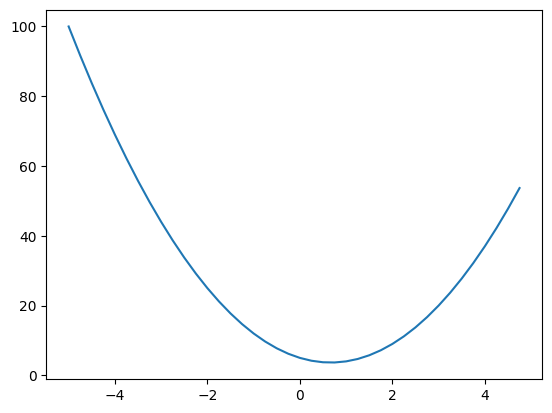

In [281]:
xs = np.arange(-5, 5, 0.25) # An array of values from -5 to 5 in steps of .25
xs
ys = f(xs)
ys
plt.plot(xs, ys)

What is the derivative of this function at different values of x?  
We know how to calculate it using calculus methods, but no one who is doing machine learning actually calculates derivatives of neural networks because that's very messy. We just need to have a good fundamental understanding of what it is. 

In [282]:
h = 0.00000001
x = 3.0
f(x) # 20
f(x + h) # We can make a prediction of what it would be by looking at the graph
(f(x + h) - f(x))/h # How much the function responded, normalized to get the slope
# If h is very small this is incorrect

14.00000009255109

A more complex example to get an intuitive understanding of derivatives

In [283]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [284]:
h = 0.0001

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2) # Since b is negative, inc. a makes d2 smaller
print('slope', (d2-d1)/h) # This is the value if we take the derivative of d relative to b

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Neural networks are massive expressions, so we need data structures that can maintain these expressions. We can build it out using the Value expressions.

In [285]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # stores the derivative - how much the val affects the final val, by default assume it's 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

# Implementing the same function as before
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
a + b # a.__add__(b)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L 

Value(data=-8.0)

In [286]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [287]:
d._op

'+'

In [288]:
# Visualization

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

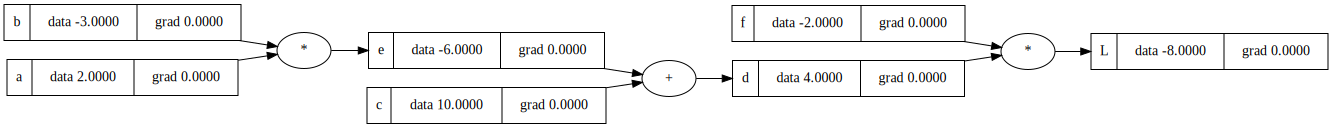

In [289]:
draw_dot(L)

## Manual Backpropagation
- Start at the end (L) and go back and calculate the gradient along all the intermediate values. We are computing the derivative of L with respect to that node.  
- L is the loss function

We can do this manually first by finding the derivative with respect to each variable. We do this by adjusting each one by a small amount h and then finding the change in L after this happened.

In [290]:
def lol():
    h = 0.0000001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h) # Add h here

lol()

1.0000000028043132


In [291]:
L.grad = 1.0

L = d * f
dL/dd = f
dL/df = d

f.grad = d
d.grad = f

In [292]:
d.grad = -2.0
f.grad = 4.0

We can check these results by adding h and recalculating L, then finding the slope.

In [293]:
def lol():
    h = 0.0000001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h # Add h here
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.0000000056086265


dL/dc?

If we change c, how does that impact L through d?

We can find the derivative of d with respect to c. dd/dc?  
d = c + e, so dd/dc = 1.0  
dd/de = 1.0 also

We can use dL/dd and dd/dc to find dL/dc using chain rule.  
Chain rule: dz/dx = dz/dy * dy/dx

dL/dc = dL/dd * dd/dc  
dL/dc = -2.0 * 1  
dL/dc = -2.0 

Since derivatives of values involved in summation are always 1, we can just think of addition as passing the value down the network.

In [294]:
c.grad = -2.0
e.grad = -2.0

We can check this by running lol() again and adding h to c and e respectively.

dL/da and dL/db?  
We can apply chain rule again to find these.

dL/de = -2.0  
de/da = b = -3.0

dL/da = dL/de * de/da  
dL/da = -2.0 * -3.0  
dL/da = 6

We can do the same thing for dL/db. de/db = a = 2.0  
dL/db = -2.0 * 2.0

In [295]:
a.grad = 6.0
b.grad = -4.0

Verify again by running lol() and adding h to a and b.

We've now filled out the entire graph.

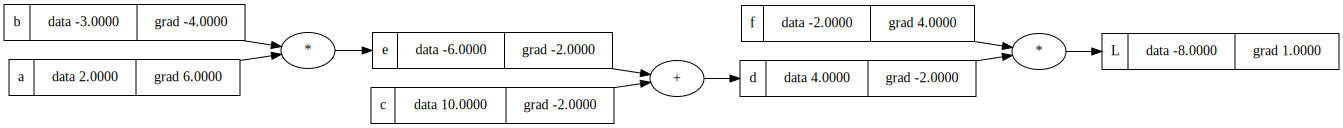

In [296]:
draw_dot(L)

## Manual Backpropagation with Neurons

Mathematical model of a neuron:
- input: axis, _x_
- synapses have weights on them, _w_
- synapses interact with neuron inputs: _xw_
- each cell body has multiple inputs from synapses, and we add them all together along with bias _b_
- _wx_ + _b_ is taken through the activation function for that cell body
- activation function is usually a squashing function like sigma or tanh

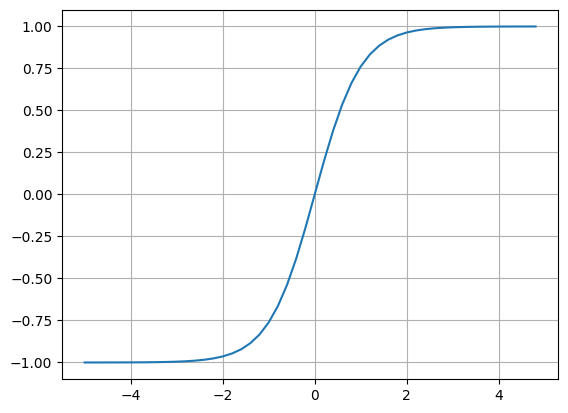

In [297]:
# tanh function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

inputs to this function are always between -1 and 1

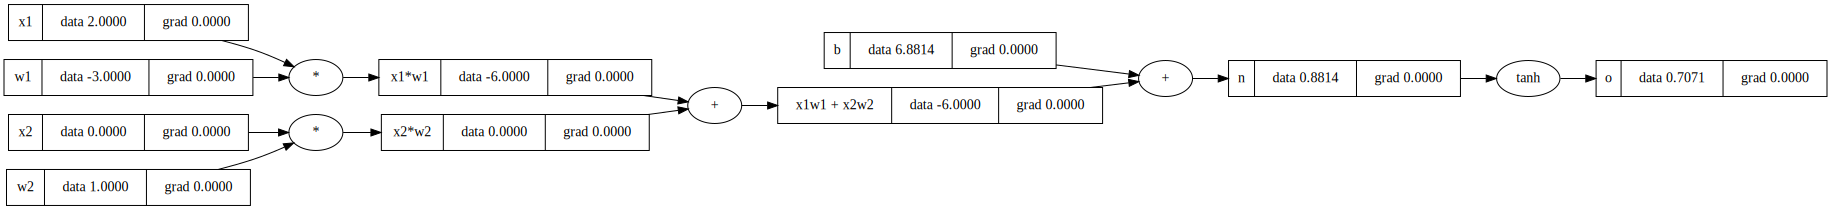

In [298]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() # Added tanh function to Value to do this
o.label = 'o'
draw_dot(o)

This is a single neuron

In [299]:
o.grad = 1.0

# We can follow through the same process as the last example to manually find the gradients for each Value

## Implementing Backpropagation into Value

In [300]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # stores the function that finds the gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

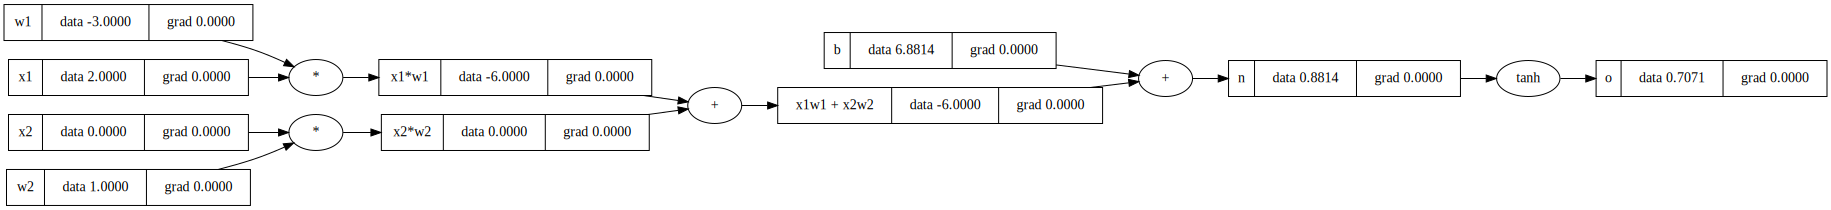

In [301]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() # Added tanh function to Value to do this
o.label = 'o'
draw_dot(o)

In [302]:
o.grad = 1.0 # Initialize the gradient
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

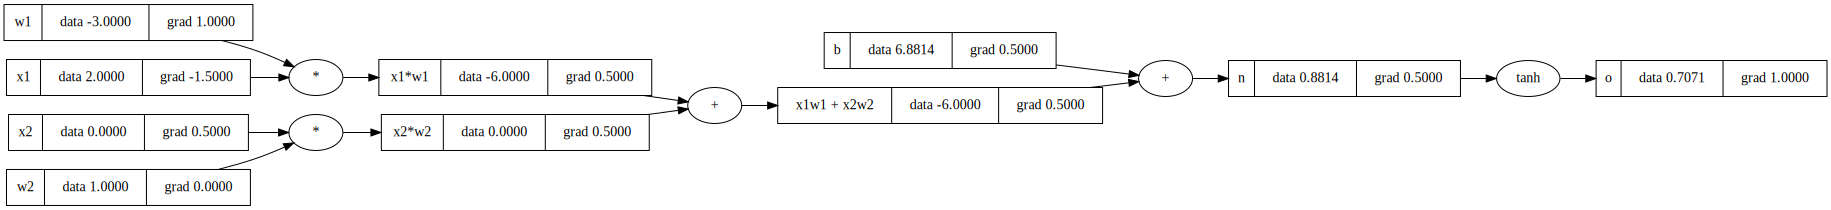

In [303]:
draw_dot(o)

How do we make it so that we don't have to call backward manually for each Value?  
We need to know the order of the graphs so we can call the functions in the correct order.  
We do this using topological sort.

In [304]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
    node._backward()

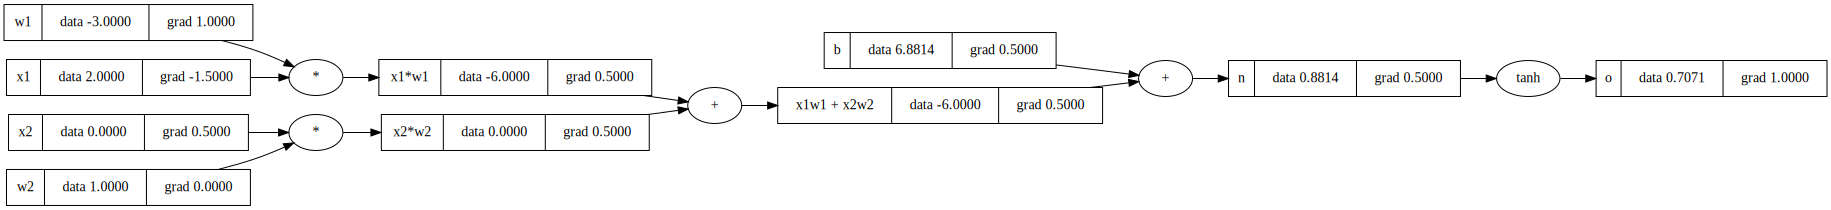

In [305]:
draw_dot(o)

We can add this to Value

In [306]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # stores the function that finds the gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

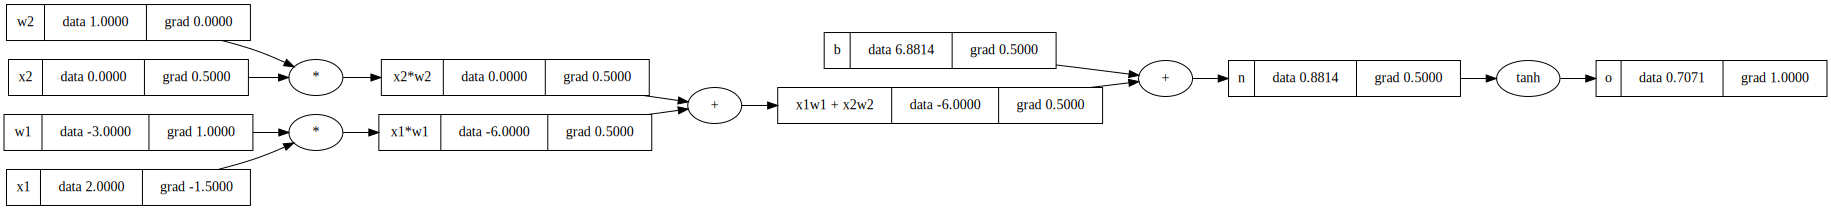

In [307]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() # Added tanh function to Value to do this
o.label = 'o'
o.backward()
draw_dot(o)

However, we have a bug!!

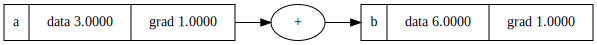

In [308]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

There are two arrows on top of each other pointing to the + in this graph.  
The gradient of a should be 2.

We will see this issue every time you use this variable more than once because when you call _backward, the gradient is overridden. The fix is to accumulate the gradients using +=

In [309]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # stores the function that finds the gradient
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

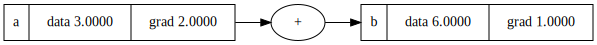

In [310]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

## Breaking up the tanh

Currently, we cannot do something like  
a = Value(1.0)  
a = a + 1

Add this functionality to each function for doing math.

In [311]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

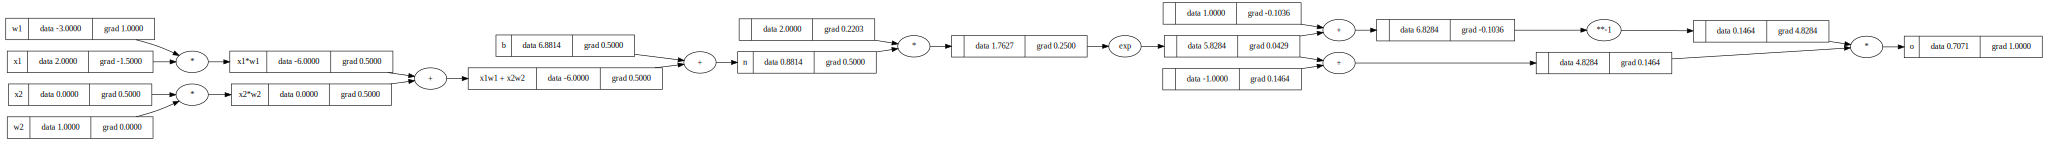

In [312]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

## Same thing using PyTorch

In [313]:
import torch

In [314]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Building a neural net

In [315]:
import random

In [316]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=0.9762970309944896)

In [317]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
x = [2.0, 3.0]
n = Layer(2, 3) # layer with 3 neurons, each with 2 weights
n(x)

[Value(data=0.41844915818416245),
 Value(data=0.1350012716171799),
 Value(data=0.9991178916968836)]

In [318]:
class MLP:
# nin: number of inputs
# nouts: a list defining the size of each of the layers
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # a neural network with 3 input neurons and 3 other layers
n(x)

Value(data=0.8252813975664882)

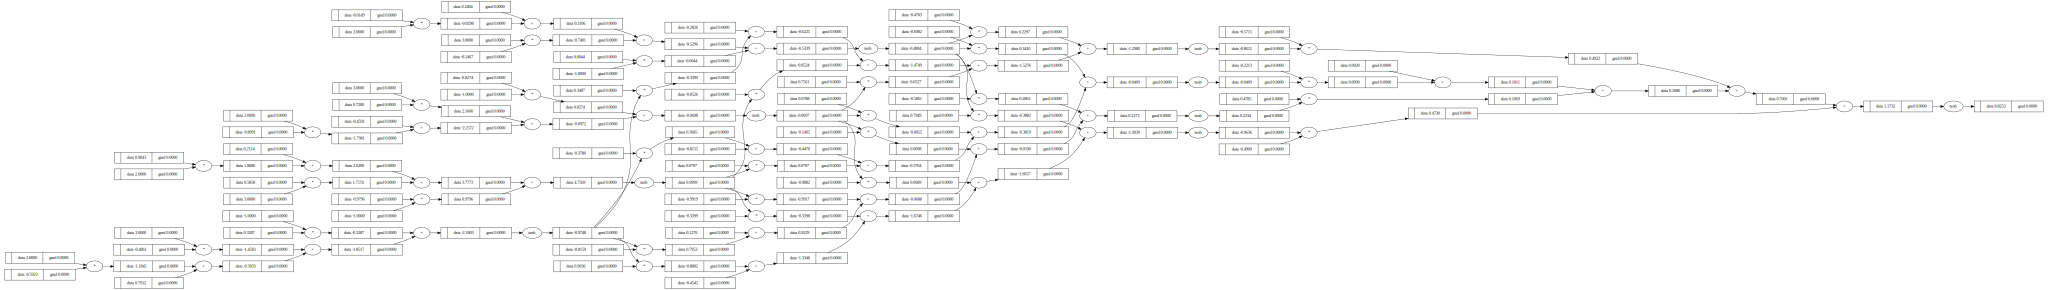

In [319]:
draw_dot(n(x))

In [320]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets for each set of inputs in xs
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8252813975664882),
 Value(data=0.3977536290314427),
 Value(data=0.3768482973189012),
 Value(data=0.7218635265581125)]

We have to calculate a number that represents how well the neural net is currently performing and how much we have to change it. This is loss.

In [321]:
# loss for each input. greater loss = more off
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

# final loss is sum of all of these 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.9573129291955347)

In [322]:
loss.backward()

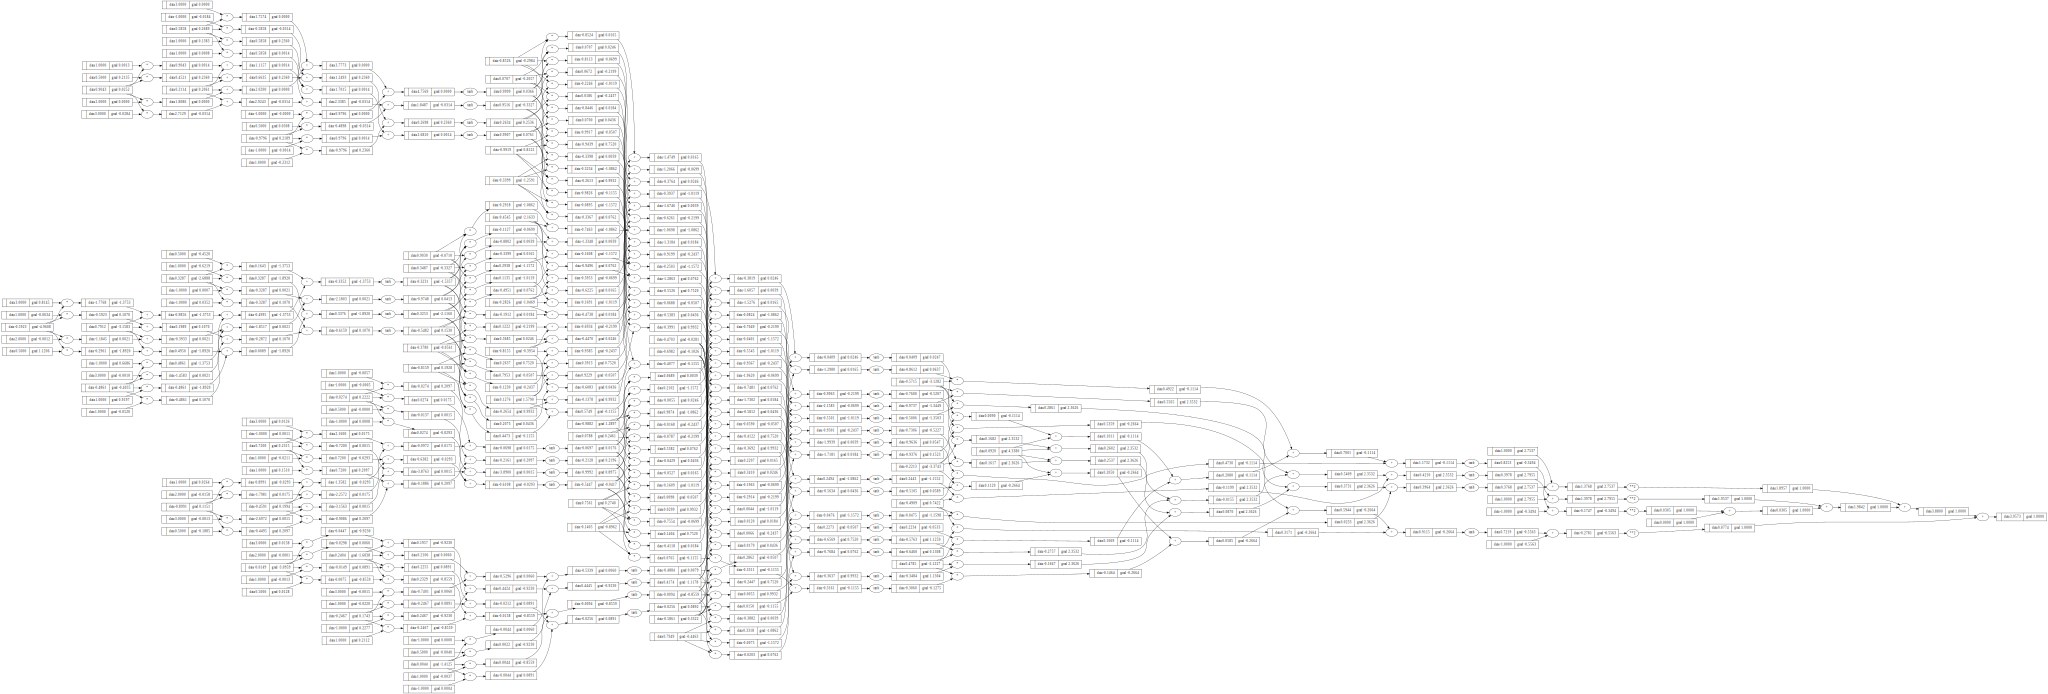

In [323]:
draw_dot(loss)

In [324]:
n.layers[0].neurons[0].w[0].grad
# This shows how much of an affect changing this weight would have on the loss

-4.960840644403731

Now we want to gather all these parameters together so we can change them at once to affect the loss.  
To do this, we add a parameters() function to each class.

In [325]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [326]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets for each set of inputs in xs
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.33296032187960345),
 Value(data=-0.5799288127644285),
 Value(data=-0.7134612463560972),
 Value(data=0.4614804472180642)]

In [327]:
# loss for each input. greater loss = more off
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

# final loss is sum of all of these 
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.3253507881191355)

In [328]:
loss.backward()

In [329]:
n.layers[0].neurons[0].w[0].grad

-1.0467060240023864

In [330]:
n.layers[0].neurons[0].w[0].data

-0.7456784746580027

For each parameter in the neural net, we want to change each one according to the loss and gradients.

In [331]:
for p in n.parameters():
    p.data += -0.01 * p.grad

After running the above, we will see the neuron's data will change a little bit.

In [332]:
n.layers[0].neurons[0].w[0].data

-0.7352114144179789

We also expect the loss to have changed.

In [333]:
ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.6216643726471527)

Smaller loss = slightly closer to predictions!  
We can keep doing this and loss will get smaller and smaller. This is called gradient descent.

## Actual training loop implementation

In [341]:
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0    
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 0.01267221839659753
1 0.012284678274478999
2 0.011918761090167136
3 0.011572784861652962
4 0.011245232050894671
5 0.010934730433868538
6 0.010640036531030059
7 0.010360021212681897
8 0.010093657158002386
9 0.00984000789902851


In [339]:
ypred

[Value(data=0.9257145230921597),
 Value(data=-0.9164314799302455),
 Value(data=-0.9247208927687091),
 Value(data=0.9695200508093539)]